In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl

from geopy.distance import geodesic
from matplotlib import pyplot as plt

%matplotlib inline
sns.set_style("whitegrid")
plt.rc("font", size=15)

print("Pandas Version: " + pd.__version__)
print("Numpy Version: " + np.__version__)
print("Seaborn Version: " + sns.__version__)

Pandas Version: 1.2.4
Numpy Version: 1.18.5
Seaborn Version: 0.11.1


In [2]:
# Switch between recalculating or reading from file to save time

READ_STATION_DISTANCES_FROM_FILE = True

In [3]:
df = pd.read_csv("../../data/call_a_bike/OPENDATA_BOOKING_CALL_A_BIKE.csv", sep=";")

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16228298 entries, 0 to 16228297
Data columns (total 17 columns):
 #   Column                     Dtype  
---  ------                     -----  
 0   BOOKING_HAL_ID             int64  
 1   CATEGORY_HAL_ID            int64  
 2   VEHICLE_HAL_ID             int64  
 3   CUSTOMER_HAL_ID            object 
 4   DATE_BOOKING               object 
 5   DATE_FROM                  object 
 6   DATE_UNTIL                 object 
 7   COMPUTE_EXTRA_BOOKING_FEE  object 
 8   TRAVERSE_USE               object 
 9   DISTANCE                   float64
 10  START_RENTAL_ZONE          object 
 11  START_RENTAL_ZONE_HAL_ID   float64
 12  END_RENTAL_ZONE            object 
 13  END_RENTAL_ZONE_HAL_ID     float64
 14  RENTAL_ZONE_HAL_SRC        object 
 15  CITY_RENTAL_ZONE           object 
 16  TECHNICAL_INCOME_CHANNEL   object 
dtypes: float64(3), int64(3), object(11)
memory usage: 2.1+ GB


In [5]:
df.head(3)

,BOOKING_HAL_ID,CATEGORY_HAL_ID,VEHICLE_HAL_ID,CUSTOMER_HAL_ID,DATE_BOOKING,DATE_FROM,DATE_UNTIL,COMPUTE_EXTRA_BOOKING_FEE,TRAVERSE_USE,DISTANCE,START_RENTAL_ZONE,START_RENTAL_ZONE_HAL_ID,END_RENTAL_ZONE,END_RENTAL_ZONE_HAL_ID,RENTAL_ZONE_HAL_SRC,CITY_RENTAL_ZONE,TECHNICAL_INCOME_CHANNEL
0,21366843,51000,143517,A821059B555C7764A2FF801180874A2FCB326222,2014-01-01 00:34:54,2014-01-01 00:34:54,2014-01-01 00:50:14,Nein,Nein,0.0,U-Bahn Baumwall,214170.0,Mönckebergstraße / Rosenstraße,131880.0,Standort,Hamburg,iPhone SRH
1,21367069,51000,119830,1EBC930DB407ACEAE2FDE23A6CA40492EA3DFBB2,2014-01-01 01:39:55,2014-01-01 01:39:55,2014-01-01 01:57:27,Nein,Nein,0.0,Bahnhof Altona Ost/Max-Brauer-Allee,131646.0,Schulterblatt/Eifflerstraße,131648.0,Standort,Hamburg,Android SRH
2,21367072,51000,143501,7AD2C1B70137479062A6DD73815835986677BB2D,2014-01-01 01:40:20,2014-01-01 01:40:20,2014-01-01 01:53:09,Nein,Nein,0.0,Weidestraße/Biedermannplatz,211922.0,Jarrestraße / Rambatzweg,138376.0,Standort,Hamburg,Techniker HH_119 (-2334-)


In [6]:
df.tail(3)

,BOOKING_HAL_ID,CATEGORY_HAL_ID,VEHICLE_HAL_ID,CUSTOMER_HAL_ID,DATE_BOOKING,DATE_FROM,DATE_UNTIL,COMPUTE_EXTRA_BOOKING_FEE,TRAVERSE_USE,DISTANCE,START_RENTAL_ZONE,START_RENTAL_ZONE_HAL_ID,END_RENTAL_ZONE,END_RENTAL_ZONE_HAL_ID,RENTAL_ZONE_HAL_SRC,CITY_RENTAL_ZONE,TECHNICAL_INCOME_CHANNEL
16228295,46385839,51000,120488,CC6405146B51242A9169AB55E88A5C472EA1B2AA,2017-05-16 07:40:17,2017-05-16 07:40:17,2017-05-16 07:50:07,Ja,Nein,0.0,Weidestraße/Biedermannplatz,211922.0,Mundsburg / Schürbeker Straße,140799.0,Standort,Hamburg,Techniker HH_119 (-2334-)
16228296,46386510,50000,116623,AE105561D195C422985C2B3BB1A790C187DA3A70,2017-05-16 08:02:12,2017-05-16 08:02:12,2017-05-23 08:02:12,Ja,Nein,NaN,NaN,NaN,NaN,NaN,NaN,Darmstadt,iPhone CAB
16228297,46386791,50000,110529,DBB967CDDB3C6D5F0C7CC7A2FF2E8CC89B5ECE6E,2017-05-16 08:11:13,2017-05-16 08:11:13,2017-05-23 08:11:13,Ja,Nein,NaN,NaN,NaN,NaN,NaN,NaN,Darmstadt,iPhone CAB


In [7]:
# Select trips made in Hamburg

trips = df[df.CITY_RENTAL_ZONE == "Hamburg"]

In [8]:
last_count = trips.shape[0]

def print_count_data():
    current_count = trips.shape[0]
    diff = current_count - last_count
    print('% s entries, diff: % s'%(current_count, diff)) 
    return current_count

In [9]:
last_count = print_count_data()

8942261 entries, diff: 0


In [10]:
# Select and rename usable columns

trips = trips[[
    "VEHICLE_HAL_ID",
    "CUSTOMER_HAL_ID",
    "DATE_FROM",
    "DATE_UNTIL",
    "START_RENTAL_ZONE",
    "START_RENTAL_ZONE_HAL_ID",
    "END_RENTAL_ZONE",
    "END_RENTAL_ZONE_HAL_ID",
    "TECHNICAL_INCOME_CHANNEL",
]].copy()
trips.columns = [
    "bike_id",
    "user_id",
    "date_from",
    "date_until",
    "start_station_name", 
    "start_station_id",
    "end_station_name",
    "end_station_id",
    "booked_via"
]

In [11]:
trips["date_from"] = pd.to_datetime(trips["date_from"])
trips["date_until"] = pd.to_datetime(trips["date_until"])

In [12]:
trips.isna().sum()

bike_id                    0
user_id                    0
date_from                  0
date_until                 0
start_station_name       429
start_station_id         246
end_station_name         255
end_station_id           250
booked_via            120066
dtype: int64

In [13]:
# Fill unknown 'booked_via' with 'Unknown' because there are a lot (120,066)
# Drop other NaN rows since the amount is negligible

trips = trips.fillna({'booked_via': 'Unknown'})
trips = trips.dropna()

In [14]:
last_count = print_count_data()

8941801 entries, diff: -460


In [15]:
# Convert float IDs to integer values

trips["start_station_id"] = trips["start_station_id"].astype(int)
trips["end_station_id"] = trips["end_station_id"].astype(int)

In [16]:
# Examining 'booked_via' that start with 'Techniker'

techniker = trips[trips["booked_via"].str.contains("Techniker")]
non_techniker = pd.concat([trips, techniker]).drop_duplicates(keep=False)

tmp = non_techniker.loc[non_techniker.user_id.isin(techniker.user_id.unique())]
print('Number of trips with a user ID that booked via Techniker before: %s' % len(tmp.index))
tmp = non_techniker.loc[~non_techniker.user_id.isin(techniker.user_id.unique())]
print('Number of trips with a user ID that did not book via Techniker before: %s' % len(tmp.index))

# Assuming 'Techniker' means maintenance personnel is probably faulty.
# Around 50% of the user IDs are contained in the non_techniker trip data set.

Number of trips with a user ID that booked via Techniker before: 4104569
Number of trips with a user ID that did not book via Techniker before: 4108149


In [17]:
techniker.sample(5)

,bike_id,user_id,date_from,date_until,start_station_name,start_station_id,end_station_name,end_station_id,booked_via
7105609,116274,FE1139EAA1E63F7628145190D1324761112AB91C,2015-08-12 11:02:31,2015-08-12 11:10:50,Harburger Ring/Neue Straße,242643,Moorstraße/Bahnhof Harburg,242358,Techniker HH_87 (-2812-)
12443164,116255,22129A949930E49C7D653F98A4A36ADEE1AA52AD,2016-08-12 09:00:30,2016-08-12 09:02:37,Amsinckstraße/ Nordkanalbrücke,218174,Amsinckstraße/ Nordkanalbrücke,218174,Techniker HH_159 (-2642-)
3628062,143825,A7682F311295D578BB8832BD76110EB895D19618,2014-10-17 20:51:47,2014-10-17 20:59:18,Lortzingstraße/Friedrichsberger Straße,213833,Lerchenfeld / Uferstraße,138375,Techniker HH_14 (-2337-)
4267096,120083,94FA872E02C2B3FBF3079B0A0A24031CAE819AAF,2014-12-23 15:02:15,2014-12-23 15:09:11,Bullerdeich/Stadtreinigung Hamburg,239807,Hammerbrook / Sachsenfeld,140790,Techniker HH_165 (-268-)
846189,119901,606E08ECED4BFE701B617DA03C63D64B052B4929,2014-04-21 22:13:52,2014-04-21 22:21:13,Emilienstraße/Fruchtallee,213825,Goebenstraße/Eppendorfer Weg,131641,Techniker HH_125 (-2224-)


In [18]:
non_techniker.sample(5)

,bike_id,user_id,date_from,date_until,start_station_name,start_station_id,end_station_name,end_station_id,booked_via
1122960,143673,963CD83ECBB170003DFAC53AA8EA51D16653C79F,2014-05-12 07:57:29,2014-05-12 08:01:27,Berliner Tor / Berlinertordamm,131652,Lohmühlenstraße / Steindamm,140791,Terminal HH_41 (-2645-)
2172622,143523,5DE7429756EDF1ADE7B09EBEA0A28C59D54B0639,2014-07-15 17:21:03,2014-07-15 17:28:35,Millerntorplatz/St.Pauli,131905,Schulterblatt/Eifflerstraße,131648,Android CAB
12638651,119670,9559A100124EC3F952EE8D829AFE51328B681509,2016-08-21 02:27:44,2016-08-21 02:45:57,Reeperbahn / Königstraße,131902,Hohenzollernring/Friedensallee,244944,iPhone SRH
15195484,143599,7E84A6CB915593EF3583348C34BA90F04932E5BC,2017-03-07 23:02:04,2017-03-07 23:09:14,Holsteinischer Kamp/ Wagnerstraße,211921,Krausestraße/Eilbektal,208295,Android SRH
3479121,120038,5B6602A66E3E489275E1B2F1980AFD8CDCA7D0BC,2014-10-07 07:24:16,2014-10-07 07:27:30,Saarlandstraße/Wiesendamm,203890,Schleidenstraße/Osterbekstraße,208307,Android SRH


In [19]:
# Create a stations data set from all unique station IDs

station_ids = sorted(
    set(trips.start_station_id.tolist() + trips.end_station_id.tolist())
)
station_ids = pd.DataFrame(station_ids, columns=['station_id'])
station_ids

,station_id
0,131543
1,131546
2,131547
3,131639
4,131640
...,...
211,256467
212,264330
213,264820
214,264821


In [20]:
# Load DB data set about stations

db_stations = pd.read_csv("../../data/call_a_bike/OPENDATA_RENTAL_ZONE_CALL_A_BIKE.csv", sep=";", decimal=",")
db_stations = db_stations[db_stations.CITY == "Hamburg"]
db_stations.sample(5)

,RENTAL_ZONE_HAL_ID,RENTAL_ZONE_HAL_SRC,NAME,CODE,TYPE,CITY,COUNTRY,LATITUDE,LONGITUDE,POI_AIRPORT_X,POI_LONG_DISTANCE_TRAINS_X,POI_SUBURBAN_TRAINS_X,POI_UNDERGROUND_X,ACTIVE_X,COMPANY,COMPANY_GROUP
350,131543,Standort,Landungsbrücke/Hafentor,2621.0,normal,Hamburg,Deutschland,9.972300,53.545700,Nein,Nein,Nein,Nein,Ja,StadtRAD Hamburg,Call a Bike
548,212607,Standort,Wiesendamm/Roggenkamp,2351.0,normal,Hamburg,Deutschland,10.042993,53.586958,Nein,Nein,Nein,Nein,Ja,StadtRAD Hamburg,Call a Bike
1050,264820,Standort,Osterstraße/Heußweg,2228.0,normal,Hamburg,Deutschland,9.952071,53.575983,Nein,Nein,Nein,Nein,Ja,StadtRAD Hamburg,Call a Bike
823,245203,Standort,Alsterdorfer Straße/Fuhlsbüttler Straße,2397.0,normal,Hamburg,Deutschland,10.032000,53.620000,Nein,Nein,Ja,Nein,Ja,StadtRAD Hamburg,Call a Bike
456,198077,Standort,Allende-Platz/Grindelhof,2215.0,normal,Hamburg,Deutschland,9.982728,53.567845,Nein,Nein,Nein,Nein,Ja,StadtRAD Hamburg,Call a Bike


In [21]:
# Select coordinates for stations from DB data

coordinates = db_stations[["RENTAL_ZONE_HAL_ID", "NAME", "LATITUDE", "LONGITUDE"]].copy()
# coordinate descriptions are incorrectly labelled in the original data set
coordinates.columns = ["station_id", "name", "longitude", "latitude"]
coordinates.dropna(inplace=True)
coordinates

,station_id,name,longitude,latitude
350,131543,Landungsbrücke/Hafentor,9.972300,53.545700
351,131546,Fischmarkt/Breite Straße,9.950880,53.546200
352,131547,Paulinenplatz/Wohlwillstraße,9.962460,53.554200
353,131639,Burgstraße/Hammer Landstraße,10.041298,53.555693
354,131640,Innocentiapark/Oberstraße,9.982110,53.577248
...,...,...,...,...
1023,256467,Röntgenstraße/Philips,10.012209,53.623481
1048,264330,Bleickenallee/Kinderkrankenhaus Altona,9.912913,53.551288
1050,264820,Osterstraße/Heußweg,9.952071,53.575983
1051,264821,Bahrenfelder Chaussee/Von-Sauer-Straße,9.910870,53.565973


We can already see that the DB data set of stations does not seem to be complete. There are more unique IDs in the bike trip data set as in the stations data set (308 rows vs. 206 rows).

In [22]:
stations = pd.merge(station_ids, coordinates, how="left", on="station_id")
stations

,station_id,name,longitude,latitude
0,131543,Landungsbrücke/Hafentor,9.972300,53.545700
1,131546,Fischmarkt/Breite Straße,9.950880,53.546200
2,131547,Paulinenplatz/Wohlwillstraße,9.962460,53.554200
3,131639,Burgstraße/Hammer Landstraße,10.041298,53.555693
4,131640,Innocentiapark/Oberstraße,9.982110,53.577248
...,...,...,...,...
211,256467,Röntgenstraße/Philips,10.012209,53.623481
212,264330,Bleickenallee/Kinderkrankenhaus Altona,9.912913,53.551288
213,264820,Osterstraße/Heußweg,9.952071,53.575983
214,264821,Bahrenfelder Chaussee/Von-Sauer-Straße,9.910870,53.565973


In [23]:
missing_info_ids = stations[stations.name.isnull()].station_id.unique()
missing_info_ids

array([138370, 194453, 194553, 194563, 225361, 238540, 238543, 241576,
       242731, 246950])

In [24]:
a = df[df.START_RENTAL_ZONE_HAL_ID.isin(missing_info_ids)].START_RENTAL_ZONE.unique()
b = df[df.END_RENTAL_ZONE_HAL_ID.isin(missing_info_ids)].END_RENTAL_ZONE.unique()

missing_locations = list(set(a)|set(b))
missing_locations

['F PS 2423 / BSC Hamburg Mobil',
 'Systemtechnik/Test Terminal',
 'F R  5156 / BSC Hamburg Mobil',
 'Rotec Schlösser BSC',
 'BSCTerminal FFM 2.OG R 2.21',
 'Maretstraße/Baererstraße',
 'F PS 1763 / BSC Hamburg Mobil',
 'Grindelberg / Bezirksamt Eimsbüttel',
 'Funkbox-BSC-HH',
 'BSC Testterminal Halle']

To match missing stations with coordinates, the information available at https://web.archive.org/web/20210313100715/https://suche.transparenz.hamburg.de/dataset/stadtrad-stationen-hamburg20 was considered. Only two stations are included: *Grindelberg / Bezirksamt Eimsbüttel* (ID 138370) and *Maretstraße/Baererstraße* (ID 242731). Coordinates for both stations can easily be added to the data set by hand.

**Coordinates**
* Grindelberg / Bezirksamt Eimsbüttel: [ 9.97782399971897, 53.57540799556665 ]
* Maretstraße / Baererstraße: [ 9.982274994484669, 53.453703999218654 ]

In [25]:
print(df[df.START_RENTAL_ZONE == "Grindelberg / Bezirksamt Eimsbüttel"].START_RENTAL_ZONE_HAL_ID.unique())
print(df[df.END_RENTAL_ZONE == "Grindelberg / Bezirksamt Eimsbüttel"].END_RENTAL_ZONE_HAL_ID.unique())

print(df[df.START_RENTAL_ZONE == "Maretstraße/Baererstraße"].START_RENTAL_ZONE_HAL_ID.unique())
print(df[df.END_RENTAL_ZONE == "Maretstraße/Baererstraße"].END_RENTAL_ZONE_HAL_ID.unique())

[138370.]
[138370.]
[242731.]
[242731.]


In [26]:
stations.loc[stations.station_id == 138370, "name"] = "Grindelberg / Bezirksamt Eimsbüttel"
stations.loc[stations.station_id == 138370, "longitude"] = 9.977824
stations.loc[stations.station_id == 138370, "latitude"] = 53.575408

stations.loc[stations.station_id == 242731, "name"] = "Maretstraße/Baererstraße"
stations.loc[stations.station_id == 242731, "longitude"] = 9.982275
stations.loc[stations.station_id == 242731, "latitude"] = 53.453704

# Drop the remaining station IDs with unknown location
stations = stations.dropna()

In [27]:
# Remove the added locations from the set of missing locations

missing_locations.remove("Grindelberg / Bezirksamt Eimsbüttel")
missing_locations.remove("Maretstraße/Baererstraße")
missing_locations

['F PS 2423 / BSC Hamburg Mobil',
 'Systemtechnik/Test Terminal',
 'F R  5156 / BSC Hamburg Mobil',
 'Rotec Schlösser BSC',
 'BSCTerminal FFM 2.OG R 2.21',
 'F PS 1763 / BSC Hamburg Mobil',
 'Funkbox-BSC-HH',
 'BSC Testterminal Halle']

In [28]:
# Remove all trips where either the start or end station is still of unknown location

nan_trips = trips[
    (trips.start_station_name.isin(missing_locations)) |
    (trips.end_station_name.isin(missing_locations))
]
trips.drop(nan_trips.index, inplace=True) 

In [29]:
last_count = print_count_data()

8923066 entries, diff: -18735


In [30]:
# Calculate duration in minutes (rounded up) for each trip

def calculate_duration_in_min(date_from, date_until):
    return np.ceil((date_until - date_from) / pd.Timedelta(minutes=1))

trips.loc[:, "duration_in_min"] = calculate_duration_in_min(trips["date_from"], trips["date_until"])
trips["duration_in_min"] = trips["duration_in_min"].astype(int)

In [31]:
# Remove trips shorter than 3 minutes starting and ending at the same station
# These are probably trips that were not intentional or canceled due to issues with the bike

mask = (trips.duration_in_min < 3) & (trips.start_station_id == trips.end_station_id)
trips = trips.drop(trips[mask].index)

In [32]:
last_count = print_count_data()

8476307 entries, diff: -446759


Duration for 75% of the trips: 22 minutes
Duration for 85% of the trips: 28 minutes
Duration for 90% of the trips: 33 minutes
Duration for 93% of the trips: 39 minutes
Duration for 95% of the trips: 49 minutes
Duration for 99% of the trips: 208 minutes


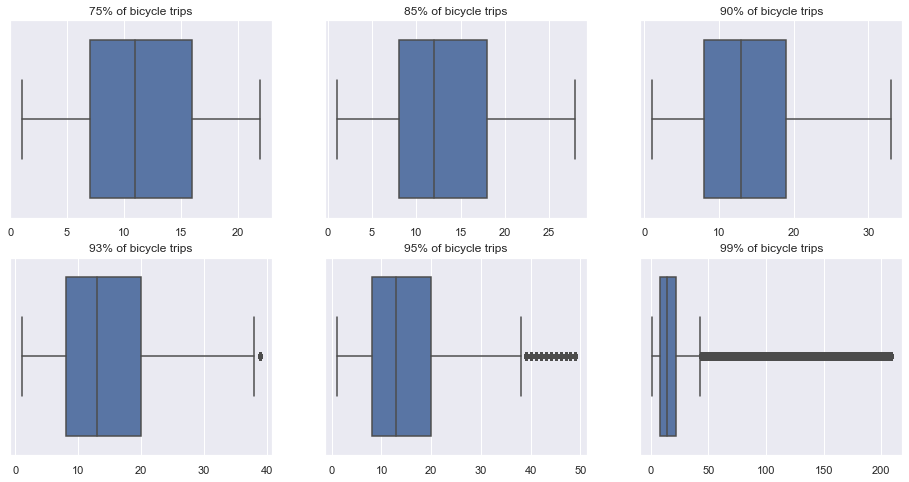

In [37]:
quantiles = [0.75, 0.85, 0.90, 0.93, 0.95, 0.99]

fig, ax = plt.subplots(2, 3, figsize=(16,8))
ax_index = 0

for quantile in quantiles:
    threshold = trips.duration_in_min.quantile(quantile)
    print("Duration for {0}% of the trips: {1} minutes".format(int(quantile*100), int(threshold)))
    sns.set()
    plot = sns.boxplot(ax=ax.flat[ax_index], x="duration_in_min", data=trips[trips.duration_in_min <= threshold])
    plot.set(xlabel=None)
    ax.flat[ax_index].set_title("{}% of bicycle trips".format(int(quantile*100), threshold))
    ax_index = ax_index + 1

plt.savefig("../../figures/duration_in_min_quantiles.png", bbox_inches="tight")
plt.show()

In [34]:
# Remove outliers based on trip duration

threshold = trips.duration_in_min.quantile(0.9)
print('Trip duration threshold: %s minutes' % threshold)

trips.drop(trips[trips.duration_in_min > threshold].index, inplace=True) 

Trip duration threshold: 33.0 minutes


In [35]:
last_count = print_count_data()

7669950 entries, diff: -806357


In [36]:
# Calculate the distance between each pair of station and save it as a python dict for easier lookup

def calculate_distance(id_x, id_y):
    station_x = stations_by_id.loc[id_x]
    station_y = stations_by_id.loc[id_y]
    x = (station_x.latitude, station_x.longitude)
    y = (station_y.latitude, station_y.longitude)
    return geodesic(x, y).km

if READ_STATION_DISTANCES_FROM_FILE:
    distances = np.load("../../calculations/station_distances.npy", allow_pickle=True).item()
else:
    stations_by_id = stations.set_index("station_id")
    ids = stations.station_id.to_numpy()
    distances = {}

    for station_x in ids:
        distances[station_x] = {}
        for station_y in ids:
            distances[station_x][station_y] = calculate_distance(station_x, station_y)

    np.save("../../calculations/station_distances.npy", distances) 

In [37]:
# Assign distance in km to each trip

trips["distance_in_km"] = trips.apply(lambda x: distances[x.start_station_id][x.end_station_id], axis=1)

In [38]:
# Calculate speed in km/h for every trip

trips["speed_in_kmh"] = trips.apply(lambda x: (x["distance_in_km"] / (x["duration_in_min"]/60)), axis=1)

Speed for 25% of the trips: 6.621667636969429 km/h
Speed for 30% of the trips: 7.049490221410206 km/h
Speed for 40% of the trips: 7.832045555266617 km/h
Speed for 50% of the trips: 8.524389105333315 km/h
Speed for 75% of the trips: 10.270404014739613 km/h
Speed for 90% of the trips: 11.861364883913364 km/h


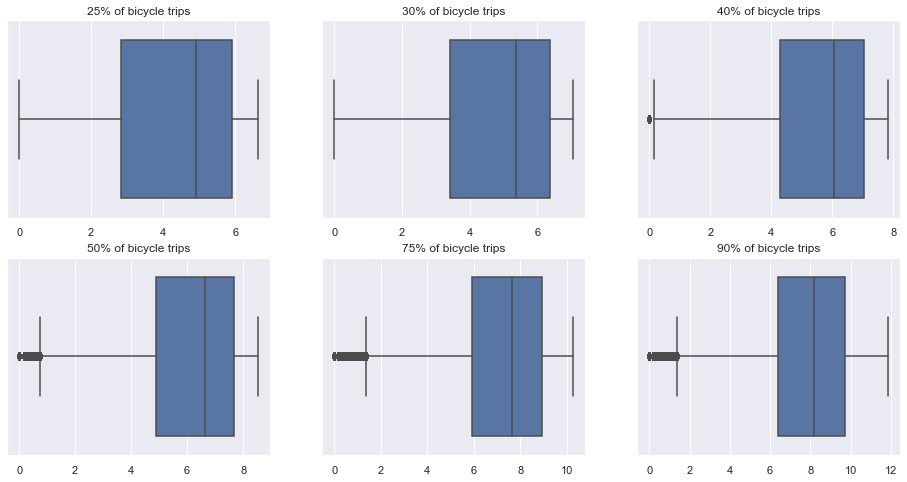

In [39]:
quantiles = [0.25, 0.3, 0.4, 0.5, 0.75, 0.9]

fig, ax = plt.subplots(2, 3, figsize=(16,8))
ax_index = 0

for quantile in quantiles:
    threshold = trips.speed_in_kmh.quantile(quantile)
    print("Speed for {0}% of the trips: {1} km/h".format(int(quantile*100), threshold))
    sns.set()
    plot = sns.boxplot(ax=ax.flat[ax_index], x="speed_in_kmh", data=trips[trips.speed_in_kmh <= threshold])
    plot.set(xlabel=None)
    ax.flat[ax_index].set_title("{}% of bicycle trips".format(int(quantile*100), threshold))
    ax_index = ax_index + 1

plt.show()

In [40]:
trips.speed_in_kmh.quantile(0.99)

14.784522922984792

In [41]:
trips.speed_in_kmh.describe()

count    7.669950e+06
mean     8.271799e+00
std      3.586595e+00
min      0.000000e+00
25%      6.621668e+00
50%      8.524389e+00
75%      1.027040e+01
max      6.745652e+02
Name: speed_in_kmh, dtype: float64

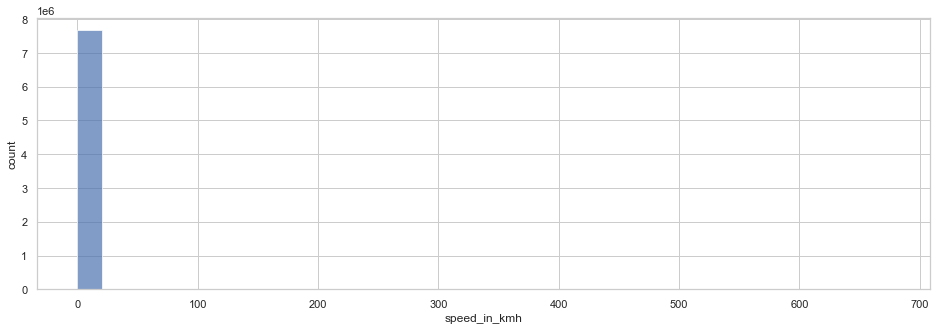

In [42]:
sns.set_style("whitegrid")

values = trips[["speed_in_kmh"]]
bins = len(pd.unique(trips.duration_in_min))
plt.figure(figsize=(16,5))
plt.hist(values, alpha=0.7, bins=bins)
plt.xlabel("speed_in_kmh")
plt.ylabel("count")
plt.savefig("../../figures/trips_hist_speed_in_kmh_raw.pdf", bbox_inches="tight")
plt.show()

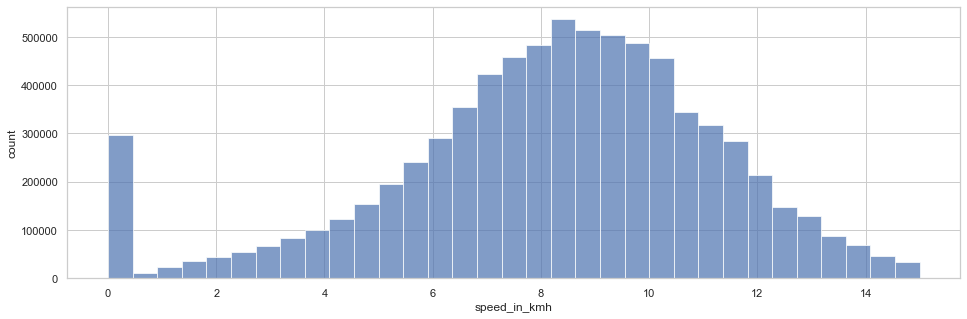

In [43]:
speed_threshold = 15

values = trips[trips.speed_in_kmh <= speed_threshold][["speed_in_kmh"]]
bins = len(pd.unique(trips.duration_in_min))
plt.figure(figsize=(16,5))
plt.hist(values, alpha=0.7, bins=bins)
plt.xlabel("speed_in_kmh")
plt.ylabel("count")
plt.savefig("../../figures/trips_hist_speed_in_kmh.pdf", bbox_inches="tight")
plt.show()

In [44]:
# Remove outliers based on speed

print('Trip speed threshold: %s km/h' % speed_threshold)

trips.drop(trips[trips.speed_in_kmh > speed_threshold].index, inplace=True) 

Trip speed threshold: 15 km/h


In [45]:
last_count = print_count_data()

7605978 entries, diff: -63972


In [46]:
# Calculate downtime beetween two trips of a user

def time_since_last_checkout(user_group):
    user_group["time_since_last_checkout"] = user_group.date_from.diff()
    return user_group

trips = trips.sort_values(by="date_from", ascending=True).groupby("user_id").apply(time_since_last_checkout)

In [47]:
trips.sample(4)

,bike_id,user_id,date_from,date_until,start_station_name,start_station_id,end_station_name,end_station_id,booked_via,duration_in_min,distance_in_km,speed_in_kmh,time_since_last_checkout
12883447,109921,789AB8F3E9F9837DD251FE3AEC046233CCE0D0BC,2016-08-31 19:55:07,2016-08-31 20:26:16,Planetarium/Hindenburgstraße,213688,Jungfernstieg / Ballindamm,131879,iPhone SRH,32,5.010718,9.395096,0 days 02:38:25
9173970,143739,67AEE1C0BC7E19739D6D997E578A91CD4B43BAFF,2016-02-04 16:01:45,2016-02-04 16:07:59,Eimsbütteler Straße/Waterloostraße,131644,Osterstraße/Bismarckstraße,131642,Terminal HH_58 (-2135-),7,0.979357,8.394489,11 days 02:50:54
12130010,120645,A8DABC6C673DD97EE53173CD0CE52DA3C1B09C03,2016-07-27 21:39:33,2016-07-27 21:52:02,Eduard-Rhein-Ufer / Schwanenwik,140800,Lange Reihe / Lohmühlenpark,138385,iPhone SRH,13,0.872378,4.026362,0 days 00:01:01
1590820,143587,6CDB2668DBF774D58A741EB338DB4F51AFDD8636,2014-06-10 14:42:06,2014-06-10 14:55:33,Bahnhof Dammtor Süd / Marseiller Straße,138382,Mundsburg / Schürbeker Straße,140799,Terminal HH_18 (-2528-),14,2.694103,11.546155,2 days 14:34:25


In [48]:
stations.sample(4)

,station_id,name,longitude,latitude
139,241777,Reeseberg/EBV-Anzengruberstraße,9.990306,53.448960
204,254727,Bahnhof Bergedorf/Johann-Meyer-Straße,10.206105,53.490496
122,218173,Rothenburgsort/Marktplatz/Lindleystraße,10.038938,53.534288
168,245203,Alsterdorfer Straße/Fuhlsbüttler Straße,10.032000,53.620000


In [49]:
# Save prepared datasets

stations.to_csv('../../data/clean/stations.csv', index=False)
trips.to_csv('../../data/clean/trips.csv', index=False)